# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

import os
import re
import shutil

# Data Preparation

In [2]:
import kagglehub

import numpy as np


from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch

import re
import json

global_mean, global_std = np.array([0.66200879, 0.49884228, 0.48171022]), np.array([
    0.23122994, 0.19965563, 0.21070801])


def get_data():

    return kagglehub.dataset_download('ismailpromus/skin-diseases-image-dataset')+'/IMG_CLASSES'


def calculate_mean_std():

    global global_mean, global_std

    dataset_path = get_data()

    initial_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    raw_dataset = datasets.ImageFolder(
        root=dataset_path,
        transform=initial_transform
    )

    raw_data_loader = DataLoader(raw_dataset, batch_size=32, shuffle=False)

    no_images = 0

    for images, _ in raw_data_loader:
        batch_mean = torch.mean(images, dim=(0, 2, 3)).numpy()
        batch_std = torch.std(images, dim=(0, 2, 3)).numpy()

        global_mean += batch_mean*images.size(0)
        global_std += batch_std*images.size(0)

        no_images += images.size(0)

    global_mean /= no_images
    global_std /= no_images


def get_data_loaders(batch_size=32):

    dataset_path = get_data()
    
    calculate_mean_std()
    
    data_transform = get_transforms(global_mean, global_std)

    training_dataset = datasets.ImageFolder(
        dataset_path, transform=data_transform['train'])
    testing_dataset = datasets.ImageFolder(
        dataset_path, transform=data_transform['test'])

    clean_class_names(training_dataset.class_to_idx)

    train_size = int(0.7*len(training_dataset))
    valid_size = int(0.15*len(training_dataset))
    test_size = len(training_dataset) - train_size - valid_size

    generator = torch.Generator().manual_seed(42)
    train_indices, valid_indices, test_indices = random_split(range(
        len(training_dataset)), [train_size, valid_size, test_size], generator=generator)

    train_dataset = torch.utils.data.Subset(
        training_dataset, train_indices.indices)
    valid_dataset = torch.utils.data.Subset(
        training_dataset, valid_indices.indices)
    test_dataset = torch.utils.data.Subset(
        testing_dataset, test_indices.indices)

    data_loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        'valid': DataLoader(valid_dataset, batch_size=batch_size, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    }
    return data_loaders


def save_class_names(class_names):
    with open('idx_to_class.json', 'w') as f:
        json.dump(class_names, f)


def clean_class_names(class_names):
    cleaned_names = {}
    for class_name, idx in class_names.items():
        match = re.search(r'\d+\.\s*(.+?)(?:\s*[-\d])', class_name)
        if match:
            clean_name = match.group(1).strip()
        else:
            clean_name = class_name  # fallback if regex fails
        cleaned_names[f"{idx}"] = clean_name

    save_class_names(cleaned_names)

    return cleaned_names

In [3]:
from torchvision import transforms


def get_transforms(mean, std):
    return {
        'train':
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAffine(scale=(0.85, 1.1), translate=(
                0.1, 0.1), degrees=10, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ColorJitter(
                brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ]),
        'test':
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    }


def get_testing_transforms(mean, std):
    return get_transforms(mean, std)['test']


def get_training_transforms(mean, std):
    return get_transforms(mean, std)['train']


# Let's build our model

In [4]:
from torchvision import datasets, transforms, models
import torch.nn as nn


class CustomEfficientNet(nn.Module):

    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()

        self.model = models.efficientnet_b0(pretrained=pretrained)
        self.model.classifier[1] = nn.Linear(
            in_features=1280, out_features=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Let's define the loss and the optimizer

In [5]:
def get_loss_function():
    return torch.nn.CrossEntropyLoss()


def get_optimizer(model, learning_rate=0.001):
    return torch.optim.Adam(model.parameters(), lr=learning_rate)


def get_scheduler(optimizer, gamma=0.1):
    return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

# Let's start training 

In [6]:
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt


def train_one_epoch(train_dl, model, criterion, optimizer):

    if torch.cuda.is_available():
        model.cuda()

    model.train()

    training_loss, correct, total = 0.0, 0, 0

    for batch_idx, (images, labels) in tqdm(
        enumerate(train_dl),
        desc="Training",
        total=len(train_dl),
        leave=True,
        ncols=80,
    ):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output, labels)

        loss.backward()

        optimizer.step()

        training_loss += loss.item()

        _, prediction = torch.max(output, 1)

        correct += ((prediction == labels).sum()).item()

        total += images.size(0)

    return training_loss/len(train_dl), (correct / total)*100


def test_one_epoch(test_dl, model, criterion):

    if torch.cuda.is_available():
        model.cuda()

    model.eval()

    test_loss, correct, total = 0.0, 0.0, 0

    with torch.no_grad():
        for batch_idx, (images, labels) in tqdm(
            enumerate(test_dl),
            desc="Testing",
            total=len(test_dl),
            leave=True,
            ncols=80,
        ):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()

            _, prediction = torch.max(output, 1)

            correct += ((prediction == labels).sum()).item()

            total += images.size(0)

    return test_loss/len(test_dl), (correct / total)*100


def validate_model(valid_dl, model, criterion):

    if torch.cuda.is_available():
        model.cuda()

    model.eval()

    eval_loss, correct, total = 0.0, 0.0, 0

    for batch_idx, (images, labels) in tqdm(
        enumerate(valid_dl),
        desc="Validation",
        total=len(valid_dl),
        leave=True,
        ncols=80,
    ):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        output = model(images)
        loss = criterion(output, labels)
        eval_loss += loss.item()

        _, prediction = torch.max(output, 1)

        correct += ((prediction == labels).sum()).item()

        total += images.size(0)

    return eval_loss/len(valid_dl), (correct / total) * 100


def model_training(model, optimizer, criterion, data_loaders, epochs, schedular, saving_path):

    train_losses, valid_losses = [], []

    valid_loss_min, _ = validate_model(
        valid_dl=data_loaders['valid'],
        model=model,
        criterion=criterion,
    )

    for epoch in range(epochs):

        training_loss, training_accuracy = train_one_epoch(
            train_dl=data_loaders['train'],
            model=model,
            criterion=criterion,
            optimizer=optimizer
        )

        train_losses.append(training_loss)

        valid_loss, valid_accuracy = validate_model(
            valid_dl=data_loaders['valid'],
            model=model,
            criterion=criterion,
        )

        valid_losses.append(valid_loss)

        schedular.step()

        if ((valid_loss_min-valid_loss)/valid_loss_min) > 0.01:
            print(
                f"New Minimum validation loss : {valid_loss}.\nSaving model...")

            torch.save(model.state_dict(), saving_path)
            valid_loss_min = valid_loss

        print(f"Epoch {epoch+1}: \n\tTraining_Loss = {training_loss}, Training_accuracy = {training_accuracy}. \n\tValidation_Loss = {valid_loss}, Validation_accuracy = {valid_accuracy}")

    return train_losses, valid_losses

def plot_loss(train_loss, valid_loss):

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
epochs = 10
model_saving_path = "./model.pth"
model = CustomEfficientNet()
optimizer = get_optimizer(model)
criterion = get_loss_function()
schedular = get_scheduler(optimizer)

data_loaders = get_data_loaders()

training_loss, valid_loss = model_training(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    data_loaders=data_loaders,
    epochs=epochs,
    schedular=schedular,
    saving_path=model_saving_path
)

print("Training completed and model saved.")

testing_loss, testing_accuracy = test_one_epoch(
    test_dl=data_loaders['test'],
    model=model,
    criterion=criterion
)
print(
    f"Testing Loss: {testing_loss}, Testing Accuracy: {testing_accuracy}")
print("Testing completed.")
print("Model training and testing completed successfully.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 162MB/s]
Validation: 100%|█████████████████████████████| 128/128 [01:07<00:00,  1.91it/s]


New Minimum validation loss : 0.86711664381437.
Saving model...
Epoch 1: 
	Training_Loss = 0.9586071933459754, Training_accuracy = 63.75545851528385. 
	Validation_Loss = 0.86711664381437, Validation_accuracy = 68.39390962671905


Validation: 100%|█████████████████████████████| 128/128 [01:09<00:00,  1.85it/s]


New Minimum validation loss : 0.5964807069394737.
Saving model...
Epoch 2: 
	Training_Loss = 0.6802870251413949, Training_accuracy = 73.77808175935182. 
	Validation_Loss = 0.5964807069394737, Validation_accuracy = 77.67681728880157


Validation: 100%|█████████████████████████████| 128/128 [01:07<00:00,  1.88it/s]


Epoch 3: 
	Training_Loss = 0.6077931709462143, Training_accuracy = 76.78749934234756. 
	Validation_Loss = 0.5923572352621704, Validation_accuracy = 77.77504911591355


Validation: 100%|█████████████████████████████| 128/128 [01:07<00:00,  1.90it/s]


Epoch 4: 
	Training_Loss = 0.5960304832418358, Training_accuracy = 77.32414373651812. 
	Validation_Loss = 0.5924500578548759, Validation_accuracy = 78.14341846758349


Validation: 100%|█████████████████████████████| 128/128 [01:06<00:00,  1.91it/s]


Epoch 5: 
	Training_Loss = 0.5947918946594501, Training_accuracy = 77.63455569000894. 
	Validation_Loss = 0.5912517555989325, Validation_accuracy = 77.94695481335953


Validation: 100%|█████████████████████████████| 128/128 [01:07<00:00,  1.90it/s]


Epoch 6: 
	Training_Loss = 0.595076466750617, Training_accuracy = 77.49250276214028. 
	Validation_Loss = 0.5916008893400431, Validation_accuracy = 78.26620825147347


Validation: 100%|█████████████████████████████| 128/128 [01:06<00:00,  1.93it/s]


Epoch 7: 
	Training_Loss = 0.5919880247878707, Training_accuracy = 77.50828642079234. 
	Validation_Loss = 0.594028134830296, Validation_accuracy = 77.99607072691552


Validation: 100%|█████████████████████████████| 128/128 [01:05<00:00,  1.96it/s]


Epoch 8: 
	Training_Loss = 0.5998713968679158, Training_accuracy = 77.26100910190982. 
	Validation_Loss = 0.5927537314128131, Validation_accuracy = 77.82416502946955


Validation: 100%|█████████████████████████████| 128/128 [01:05<00:00,  1.96it/s]


Epoch 9: 
	Training_Loss = 0.5979674630092852, Training_accuracy = 77.42410690798127. 
	Validation_Loss = 0.5917071446310729, Validation_accuracy = 77.84872298624754


Validation: 100%|█████████████████████████████| 128/128 [01:05<00:00,  1.95it/s]


New Minimum validation loss : 0.5877428725361824.
Saving model...
Epoch 10: 
	Training_Loss = 0.5983850199867178, Training_accuracy = 77.2767927605619. 
	Validation_Loss = 0.5877428725361824, Validation_accuracy = 78.1188605108055
Training completed and model saved.


Testing: 100%|████████████████████████████████| 128/128 [00:40<00:00,  3.14it/s]

Testing Loss: 0.5877918067853898, Testing Accuracy: 77.36867943053511
Testing completed.
Model training and testing completed successfully.


**Our model has 77~78% testing accuracy !!**

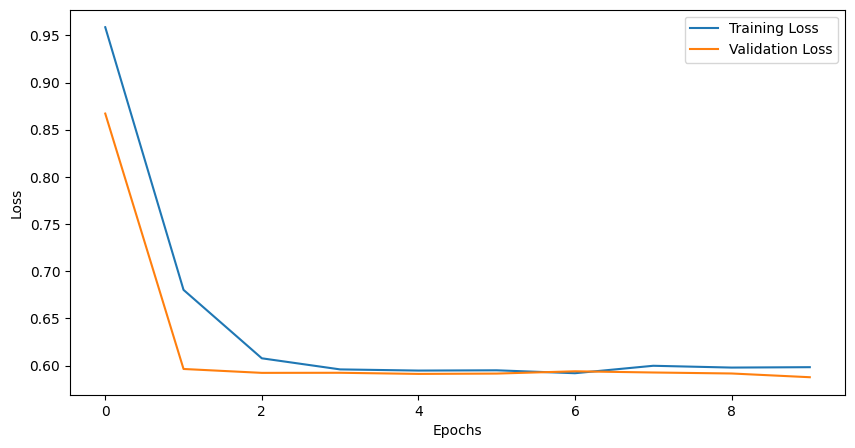

In [8]:
plot_loss(training_loss, valid_loss)